In [5]:
import torch
import torch.nn as nn
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [6]:
!unzip /content/img_cls_weather_dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/weather-dataset/dataset/frost/3922.jpg  
  inflating: /content/weather-dataset/dataset/frost/3923.jpg  
  inflating: /content/weather-dataset/dataset/frost/3924.jpg  
  inflating: /content/weather-dataset/dataset/frost/3925.jpg  
  inflating: /content/weather-dataset/dataset/frost/3926.jpg  
  inflating: /content/weather-dataset/dataset/frost/3927.jpg  
  inflating: /content/weather-dataset/dataset/frost/3928.jpg  
  inflating: /content/weather-dataset/dataset/frost/3929.jpg  
  inflating: /content/weather-dataset/dataset/frost/3930.jpg  
  inflating: /content/weather-dataset/dataset/frost/3931.jpg  
  inflating: /content/weather-dataset/dataset/frost/3932.jpg  
  inflating: /content/weather-dataset/dataset/frost/3933.jpg  
  inflating: /content/weather-dataset/dataset/frost/3934.jpg  
  inflating: /content/weather-dataset/dataset/frost/3935.jpg  
  inflating: /content/weather-dataset/dataset/frost/3936.jpg  
  in

In [7]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [8]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
      for label_idx, class_name in enumerate(
        sorted(os.listdir(root_dir))
      )
}

In [9]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
  class_dir = os.path.join(root_dir, class_name)
  for img_name in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_name)
    img_paths.append(img_path)
    labels.append(label_idx)

In [10]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    shuffle=is_shuffle,
    random_state=seed
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [11]:
class WeatherDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.img_paths = X
    self.labels = y
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert('RGB')

    if self.transform:
      img = self.transform(img)

    return img, self.labels[idx]

In [12]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0

  return normalized_img

In [13]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [14]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [15]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.downsample = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    shortcut = x.clone()
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x += self.downsample(shortcut)
    x = self.relu(x)

    return x

In [16]:
class ResNet(nn.Module):
  def __init__(self, residual_block, n_blocks_lst, n_classes):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
    self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
    self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
    self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
    self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.classifier = nn.Linear(512, n_classes)

  def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
    blocks = []
    first_block = residual_block(in_channels, out_channels, stride)
    blocks.append(first_block)
    for i in range(1, n_blocks):
      block = residual_block(out_channels, out_channels, stride)
      blocks.append(block)

    blocks_sequential = nn.Sequential(*blocks)

    return blocks_sequential

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.classifier(x)

    return x

In [17]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [21]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    accuracy = correct / total

    return loss, accuracy

In [24]:
def fit(model, train_loader, val_loader, criterion, optimizer, epochs, device):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    train_batch_losses = []
    model.train()

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      train_batch_losses.append(loss.item())

      loss.backward()
      optimizer.step()

    train_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses

In [25]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    device
)

EPOCH 1:	Train loss: 1.1382	Val loss: 24.5042
EPOCH 2:	Train loss: 1.0951	Val loss: 3.2178
EPOCH 3:	Train loss: 1.0753	Val loss: 21.3611
EPOCH 4:	Train loss: 1.0203	Val loss: 2.6870
EPOCH 5:	Train loss: 0.9817	Val loss: 1.9548
EPOCH 6:	Train loss: 0.9701	Val loss: 1.7976
EPOCH 7:	Train loss: 0.8998	Val loss: 1.6920
EPOCH 8:	Train loss: 0.8930	Val loss: 1.8938
EPOCH 9:	Train loss: 0.8619	Val loss: 1.6832
EPOCH 10:	Train loss: 0.8293	Val loss: 1.6665
EPOCH 11:	Train loss: 0.7917	Val loss: 1.3532
EPOCH 12:	Train loss: 0.7637	Val loss: 1.5034
EPOCH 13:	Train loss: 0.7732	Val loss: 1.3720
EPOCH 14:	Train loss: 0.7429	Val loss: 1.4499
EPOCH 15:	Train loss: 0.7111	Val loss: 1.3508
EPOCH 16:	Train loss: 0.6823	Val loss: 1.2749
EPOCH 17:	Train loss: 0.6613	Val loss: 1.1797
EPOCH 18:	Train loss: 0.6621	Val loss: 1.2911
EPOCH 19:	Train loss: 0.6282	Val loss: 1.2226
EPOCH 20:	Train loss: 0.6106	Val loss: 1.2301
EPOCH 21:	Train loss: 0.5905	Val loss: 1.3060
EPOCH 22:	Train loss: 0.5779	Val loss: 1.

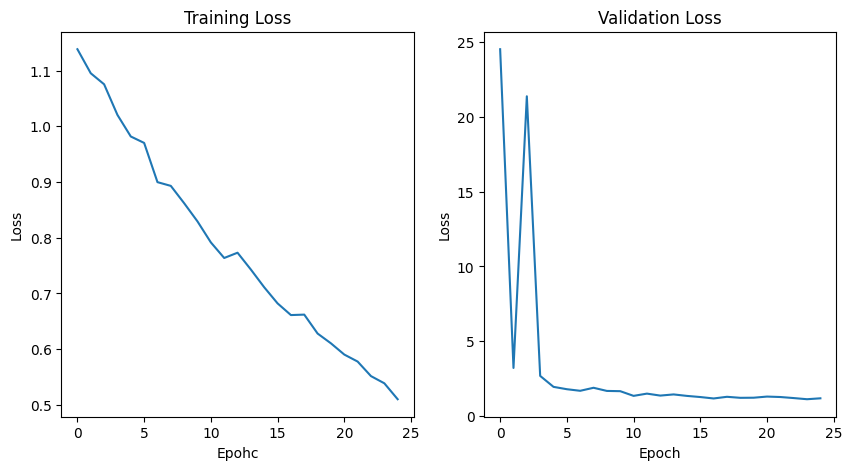

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_losses)
ax[0].set(xlabel='Epohc', ylabel='Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_losses)
ax[1].set(xlabel='Epoch', ylabel='Loss')
ax[1].set_title('Validation Loss')

plt.show()

In [29]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)
print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)


Evaluation on val/test dataset
Val accuracy: 0.6919155134741443
Test accuracy: 0.7147016011644832
